In [1]:
!ls

Jitter Plots.ipynb           praat.Collection
README.md                    scripts
SVD                          testSVD
SVD jitter shimmer hnr.ipynb testSVD group plotting.ipynb
archived                     testSVD practice.ipynb
data


In [2]:
# Initialize
from tqdm import tqdm
from time import sleep
import glob
import parselmouth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# filepath for the dataset
# root = "/Users/leochoo/dev/GP2-dev/SVD"
root = "./testSVD"

my_data_path = root + "/my_data"
healthy_path = root + "/healthy"
patho_path = root + "/pathological"

In [3]:
def get_voice_data(_path):
    # select .wav files only
    wav_files = glob.glob(_path + "/*.wav")

    n_list = []
    tone_list = []
    syllab_list = []

    j_list = []
    s_list = []
    h_list = []

    # for wav_file in wav_files:
    for wav_file in tqdm(wav_files): # tqdm shows the progress bar
        sound = parselmouth.Sound(wav_file) # sound object from wav file
        pitch = sound.to_pitch()
        pulses = parselmouth.praat.call([sound, pitch], "To PointProcess (cc)")

        # name analysis
        name = os.path.basename(wav_file).split(".")[0]  
        
        ## tone
        if "l" in name:
            tone_list.append("l")
        elif "n" in name:
            tone_list.append("n")
        elif "h" in name:
            tone_list.append("h")

        ## syllable
        if "a" in name:
            syllab_list.append("a")
        elif "i" in name:
            syllab_list.append("i")
        elif "u" in name:
            syllab_list.append("u")
        # jitter
        jitter_local = parselmouth.praat.call(pulses, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3) * 100

        # shimmer
        shimmer_local = parselmouth.praat.call([sound, pulses], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

        # HNR
        harmonicity = parselmouth.praat.call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
        hnr = parselmouth.praat.call(harmonicity, "Get mean", 0, 0)

        # Append to dataframe
        n_list.append(name)
        j_list.append(jitter_local)
        s_list.append(shimmer_local)
        h_list.append(hnr)


    # create dataframe
    df = pd.DataFrame({"Name":pd.Series(n_list),
                        "Type": np.nan,
                        "Tone": pd.Series(tone_list),
                        "Syllab": pd.Series(syllab_list),
                           "Jitter":pd.Series(j_list),
                           "Shimmer":pd.Series(s_list),
                           "HNR":pd.Series(h_list)})
    df["Type"]= _path.split("/")[-1] # identify type: my_data, healthy, functional etc...
    df = df.dropna()
    return df

In [4]:
# Get Data

## control
healthy_df = get_voice_data(healthy_path)

## patho
functional_df = get_voice_data(patho_path + "/functional")
hyperfunctional_df = get_voice_data(patho_path + "/hyperfunctional")
organic_df = get_voice_data(patho_path + "/organic")
psychogenic_df = get_voice_data(patho_path + "/psychogenic")

## my data
my_data_df = get_voice_data(my_data_path)

100%|██████████| 9/9 [00:01<00:00,  4.64it/s]


In [5]:
# Combine to one dataframe
frames = [my_data_df, healthy_df, functional_df, hyperfunctional_df, organic_df, psychogenic_df]
total_df = pd.concat(frames, keys=["my_data", "healthy_df", "functional", "hyperfunctional", "organic", "psychogenic"])


In [6]:
total_df

Name         Type Tone Syllab    Jitter   Shimmer  \
my_data     0   myd_a_h      my_data    h      a  0.222252  0.017838   
            1   myd_a_l      my_data    l      a  0.487569  0.023036   
            2   myd_a_n      my_data    n      a  0.222252  0.017838   
            3   myd_u_n      my_data    n      u  0.164563  0.011110   
            4   myd_u_l      my_data    l      u  0.279021  0.013981   
...                 ...          ...  ...    ...       ...       ...   
psychogenic 22  151-a_l  psychogenic    l      a  0.100698  0.010602   
            23  366-u_n  psychogenic    n      u  0.201356  0.015767   
            24  741-a_h  psychogenic    h      a  0.281613  0.026882   
            25  366-u_l  psychogenic    l      u  0.389981  0.039966   
            26  151-a_n  psychogenic    n      a  0.448863  0.024517   

                      HNR  
my_data     0   28.288537  
            1   21.677873  
            2   28.288537  
            3   30.354595  
            4   28.079217  
...                   ...  
psychogenic 22  32.236174  
            23  31.531414  
            24  28.802297  
            25  23.895287  
            26  23.677346  

[108 rows x 7 columns]

In [7]:
# Melt data
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["Jitter"], value_name="%")
display(dd)

,Type,Tone,variable,%
0,my_data,h,Jitter,0.222252
1,my_data,l,Jitter,0.487569
2,my_data,n,Jitter,0.222252
3,my_data,n,Jitter,0.164563
4,my_data,l,Jitter,0.279021
...,...,...,...,...
103,psychogenic,l,Jitter,0.100698
104,psychogenic,n,Jitter,0.201356
105,psychogenic,h,Jitter,0.281613
106,psychogenic,l,Jitter,0.389981


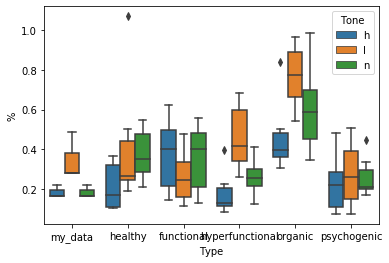

In [8]:
# Graph Jitter /a/ l/n/h tones

sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

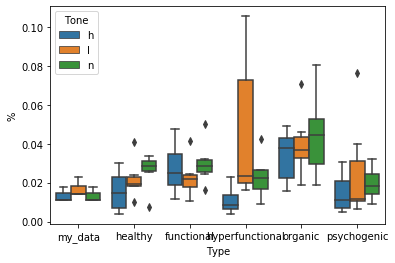

In [9]:
# Graph Shimmer
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["Shimmer"], value_name="%")

sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

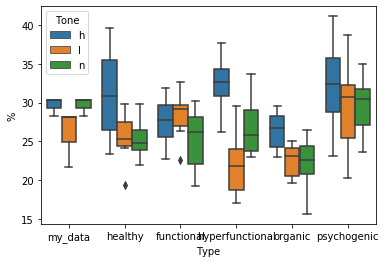

In [10]:
# Graph HNR
dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=["HNR"], value_name="%")

sns.boxplot(x="Type", y="%", data=dd, hue="Tone")

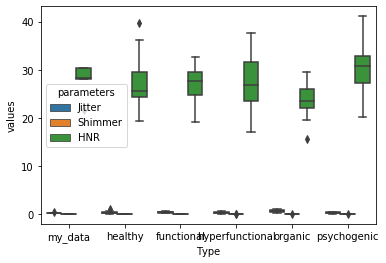

In [11]:
# Graph jitter, shimmer, hnr for all types

dd = pd.melt(total_df, id_vars=["Type"], var_name="parameters", value_vars=["Jitter","Shimmer","HNR"], value_name="values")

sns.boxplot(x="Type", y="values", data=dd, hue="parameters")

# Now graphing all scenarios

# Jitter

## Simple Tone comparisons on all vowels

## Simple Vowel Comparisons on all tones

## Tone comparisons on the same vowel
* /a/ - l,n,h
* /i/ - l,n,h
* /u/ - l,n,h
## Vowel comparison over the same tone
* l - a,i,u
* n - a,i,u
* h - a,i,u

# Shimmer
# HNR

repeat the above?

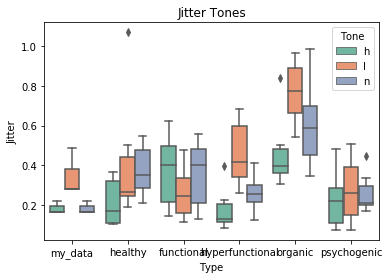

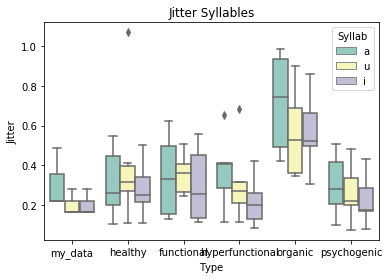

In [63]:
generate_plots_by_type("Jitter")

In [62]:
# function to generate graph based on one fixed tone or syllable
def generate_plots_by_type(_variable, _tone="", _syllab=""):
    global total_df
    if _syllab != "": #syllab fixed, tone comparison
        df = total_df.loc[total_df.Syllab == _syllab]
        dd = pd.melt(df, id_vars=["Type", "Tone"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Tone", palette="Set2").set_title(_variable + " /" + _syllab + "/")
        plt.show()
    elif _tone != "": # tone fixed, syllab comparison
        df = total_df.loc[total_df.Tone == _tone]
        dd = pd.melt(df, id_vars=["Type", "Syllab"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Syllab", palette="Set3").set_title(_variable + " " + _tone)
        plt.show()
    else:
        # show all simple comparisons
        dd = pd.melt(total_df, id_vars=["Type", "Tone"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Tone", palette="Set2").set_title(_variable + " Tones")
        plt.show()
        dd = pd.melt(total_df, id_vars=["Type", "Syllab"], value_vars=[_variable], value_name=_variable)
        sns.boxplot(x="Type", y=_variable, data=dd, hue="Syllab", palette="Set3").set_title(_variable + " Syllables")
        plt.show()

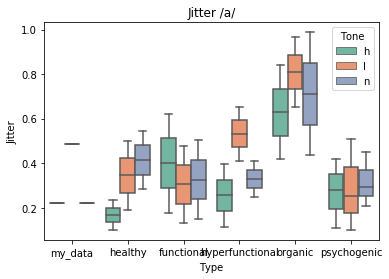

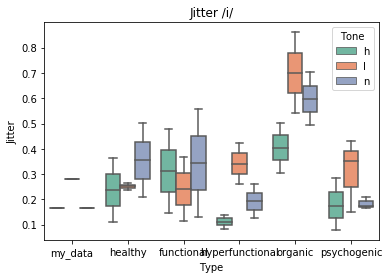

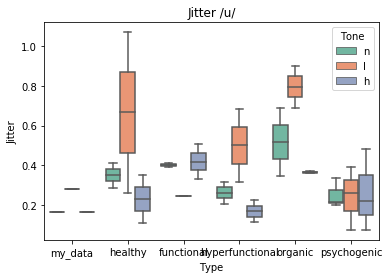

In [66]:
# /a/
generate_plots_by_type("Jitter", _syllab="a")
# /i/
generate_plots_by_type("Jitter", _syllab="i")
# /u/
generate_plots_by_type("Jitter", _syllab="u")

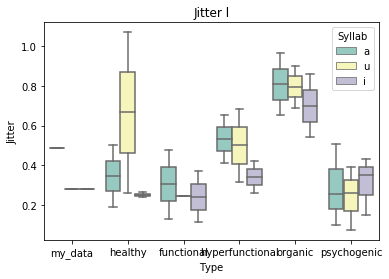

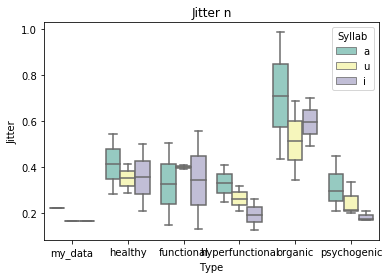

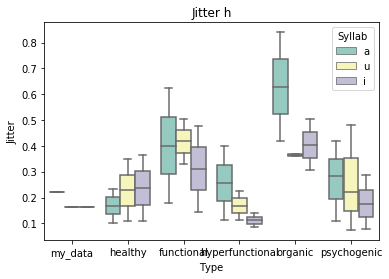

In [67]:
# l
generate_plots_by_type("Jitter", _tone="l")
# n
generate_plots_by_type("Jitter", _tone="n")
# h
generate_plots_by_type("Jitter", _tone="h")

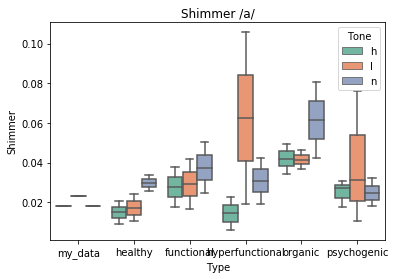

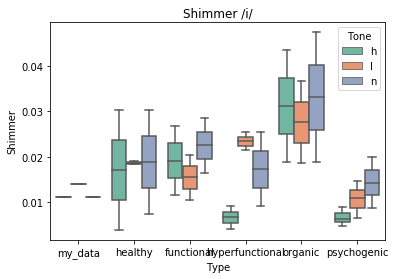

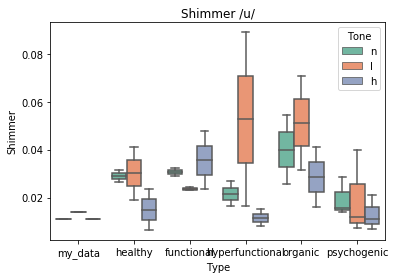

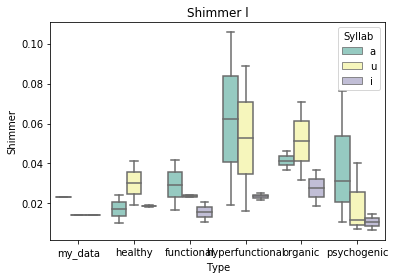

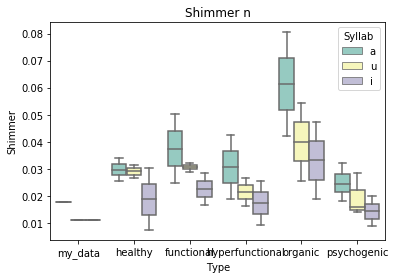

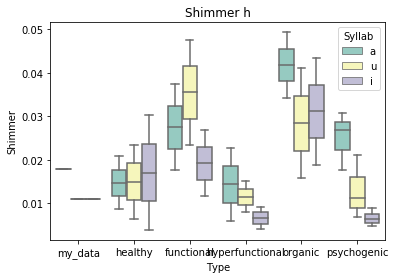

In [68]:
# /a/
generate_plots_by_type("Shimmer", _syllab="a")
# /i/
generate_plots_by_type("Shimmer", _syllab="i")
# /u/
generate_plots_by_type("Shimmer", _syllab="u")

# l
generate_plots_by_type("Shimmer", _tone="l")
# n
generate_plots_by_type("Shimmer", _tone="n")
# h
generate_plots_by_type("Shimmer", _tone="h")

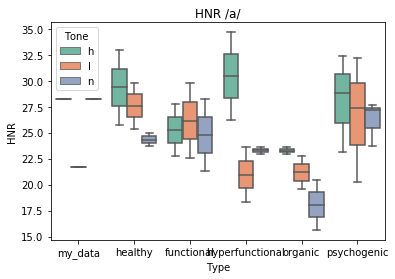

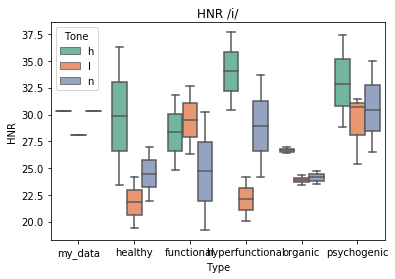

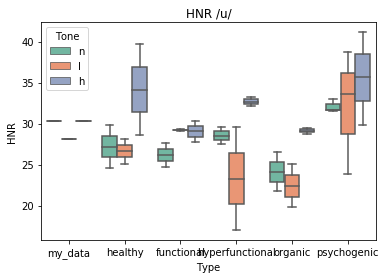

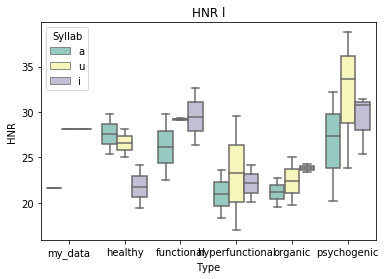

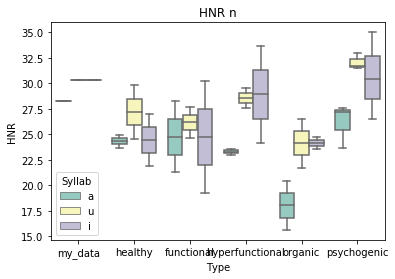

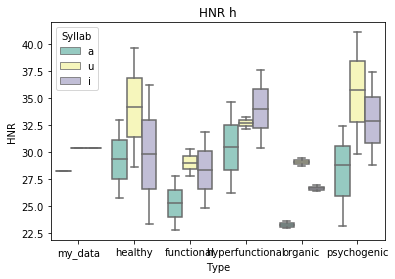

In [69]:
# /a/
generate_plots_by_type("HNR", _syllab="a")
# /i/
generate_plots_by_type("HNR", _syllab="i")
# /u/
generate_plots_by_type("HNR", _syllab="u")

# l
generate_plots_by_type("HNR", _tone="l")
# n
generate_plots_by_type("HNR", _tone="n")
# h
generate_plots_by_type("HNR", _tone="h")